# Binary Classification

Creating and evaluating a binary classification model. 





## Objectives:

  * Convert a regression question into a classification question.
  * Modifing the classification threshold and determine how that modification influences the model
  * Experiment with different classification metrics to determine model's effectiveness.

## The Dataset

Like the previous notebook, this notebook uses the California Housing Dataset.


The following code imports the modules

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
from matplotlib import pyplot as plt

# The following lines adjust the granularity 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format
tf.keras.backend.set_floatx('float32')


## Importing the datasets 

In [2]:
train_df = pd.read_csv("data/california_housing_train.csv")
test_df = pd.read_csv("data/california_housing_test.csv")
train_df = train_df.reindex(np.random.permutation(train_df.index)) # shuffling the training set

In [3]:
train_df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
16220,-122.5,37.8,52.0,2684.0,574.0,1395.0,549.0,3.9,323800.0
5181,-118.1,33.9,38.0,1475.0,269.0,827.0,265.0,4.8,191600.0
13216,-121.9,37.3,52.0,2125.0,431.0,1014.0,443.0,5.8,281100.0
12971,-121.8,39.8,17.0,5273.0,1177.0,2446.0,1199.0,1.9,89900.0
6848,-118.3,34.0,48.0,2010.0,445.0,1208.0,404.0,1.7,95800.0
...,...,...,...,...,...,...,...,...,...
17,-114.7,32.8,21.0,44.0,33.0,64.0,27.0,0.9,25000.0
725,-117.0,32.7,19.0,1469.0,275.0,1010.0,292.0,3.6,150400.0
4455,-118.0,33.7,26.0,1483.0,251.0,738.0,235.0,6.0,271400.0
5431,-118.2,34.2,46.0,1508.0,261.0,674.0,255.0,3.6,155400.0


In [4]:
train_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207300.9
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,115983.8
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,14999.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119400.0
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180400.0
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265000.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500001.0


## Normalizing values

When creating a model with multiple features, the values of each feature should have roughly the same range.

A **Z-score** is the number of standard deviations from the mean for a particular value.

  * mean is 60
  * standard deviation is 10

The value 75 would have a Z-score of:

```
  Z-score = (75 - 60) / 10 = +1.5
```


In [5]:
# Calculating the Z-scores of each column in the training set

train_df_mean = train_df.mean()
train_df_std = train_df.std()
train_df_norm = (train_df - train_df_mean)/train_df_std


train_df_norm

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
16220,-1.5,1.0,1.9,0.0,0.1,-0.0,0.1,0.0,1.0
5181,0.7,-0.8,0.7,-0.5,-0.6,-0.5,-0.6,0.5,-0.1
13216,-1.2,0.8,1.9,-0.2,-0.3,-0.4,-0.2,1.0,0.6
12971,-1.1,1.9,-0.9,1.2,1.5,0.9,1.8,-1.0,-1.0
6848,0.6,-0.8,1.5,-0.3,-0.2,-0.2,-0.3,-1.2,-1.0
...,...,...,...,...,...,...,...,...,...
17,2.4,-1.3,-0.6,-1.2,-1.2,-1.2,-1.2,-1.6,-1.6
725,1.3,-1.4,-0.8,-0.5,-0.6,-0.4,-0.5,-0.2,-0.5
4455,0.8,-0.9,-0.2,-0.5,-0.7,-0.6,-0.7,1.1,0.6
5431,0.7,-0.7,1.4,-0.5,-0.7,-0.7,-0.6,-0.2,-0.4


In [6]:
# Calculating the Z-scores of each column in the test set

test_df_mean = test_df.mean()
test_df_std  = test_df.std()
test_df_norm = (test_df - test_df_mean)/test_df_std

test_df_norm

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-1.2,0.8,-0.1,0.6,0.3,0.1,0.3,1.5,1.2
1,0.6,-0.6,1.1,-0.5,-0.5,-0.6,-0.6,-0.1,-0.3
2,0.9,-0.9,-0.1,0.5,-0.1,0.1,0.0,1.1,0.6
3,0.6,-0.9,-0.1,-1.2,-1.2,-1.3,-1.3,1.3,1.1
4,-0.0,0.3,-0.8,-0.6,-0.7,-0.5,-0.7,-0.5,-1.1
...,...,...,...,...,...,...,...,...,...
2995,-0.1,-0.6,-0.5,-0.5,0.3,-0.1,0.3,-1.4,0.2
2996,0.7,-0.7,-0.1,1.2,1.3,2.0,1.5,-0.2,0.3
2997,-0.1,0.3,-1.5,-0.8,-0.8,-0.7,-0.7,-0.8,-1.3
2998,1.2,-0.7,0.9,-1.2,-1.2,-1.3,-1.3,-0.3,-0.4


## Creating a binary label

In classification, the label for every example must be binary. Tthe label in the California housing dataset `median_house_value`, contains floating-point values like 80,100 or 85,700 rather than 0s and 1s.

So we create a new column named `median_house_value_is_high` in both the training set and the test set. If the `median_house_value` is higher than a certain threshold, then we set `median_house_value_is_high` to 1. Otherwise, set `median_house_value_is_high` to 0. 


In [7]:
threshold = 265000 # 75% of median house values
train_df_norm["median_house_value_is_high"] = (train_df["median_house_value"] > threshold).astype(float) 
test_df_norm["median_house_value_is_high"] =  (test_df["median_house_value"] > threshold).astype(float)

# astype(float) converts True and False to 1s and 0s

train_df_norm["median_house_value_is_high"]

16220   1.0
5181    0.0
13216   1.0
12971   0.0
6848    0.0
         ..
17      0.0
725     0.0
4455    1.0
5431    0.0
16916   0.0
Name: median_house_value_is_high, Length: 17000, dtype: float64

## Representing features in feature columns


In [8]:
feature_columns = []

# numerical feature column to represent median_income.
median_income = tf.feature_column.numeric_column("median_income")
feature_columns.append(median_income)

# numerical feature column to represent total_rooms.
tr = tf.feature_column.numeric_column("total_rooms")
feature_columns.append(tr)

# feature columns into layers
feature_layer = layers.DenseFeatures(feature_columns)


feature_layer(dict(train_df_norm))

<tf.Tensor: shape=(17000, 2), dtype=float32, numpy=
array([[ 0.0136896 ,  0.01850301],
       [ 0.46260455, -0.5360976 ],
       [ 1.0140792 , -0.23792523],
       ...,
       [ 1.1091448 , -0.5324278 ],
       [-0.15338264, -0.5209596 ],
       [-1.2320677 , -0.30352315]], dtype=float32)>

## Defining functions that build and train model

  * `create_model(my_learning_rate, feature_layer, my_metrics)`
  * `train_model(model, dataset, epochs, label_name, batch_size, shuffle)`z

and using sigmoid as the activation function

In [9]:
"""Creating a simple classification model"""
def create_model(my_learning_rate, feature_layer, my_metrics):

  model = tf.keras.models.Sequential()

  
  model.add(feature_layer)

  # sigmoid function.
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                  activation=tf.sigmoid),)

  # we will use a different loss function for classification     
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),                                                   
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)

  return model        



"""Feed a dataset into the model in order to train it."""
def train_model(model, dataset, epochs, label_name,
                batch_size=None, shuffle=True):
  

  
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name)) 
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle)
  
  
  epochs = history.epoch

  # isolating the classification metric for each epoch
  hist = pd.DataFrame(history.history)

  return epochs, hist    

## Defining a plotting function

Shows how various classification metrics change with each epoch.

In [10]:
 """Ploting a curve of one or more classification metrics vs epoch"""  
def plot_curve(epochs, hist, list_of_metrics):
 
  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()


## Invoking create, train, and plot function


In [11]:
import warnings
warnings.filterwarnings('ignore') 
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

#suppressing warnings

Epoch 1/20
170/170 [==============================] - 0s 1ms/step - loss: 0.8581 - accuracy: 0.1816 - recall: 0.5427 - precision: 0.1615
Epoch 2/20
170/170 [==============================] - 0s 1ms/step - loss: 0.7515 - accuracy: 0.1708 - recall: 0.5458 - precision: 0.1600
Epoch 3/20
170/170 [==============================] - 0s 1ms/step - loss: 0.6654 - accuracy: 0.1704 - recall: 0.5750 - precision: 0.1657
Epoch 4/20
170/170 [==============================] - 0s 1ms/step - loss: 0.5984 - accuracy: 0.4128 - recall: 0.5187 - precision: 0.2172
Epoch 5/20
170/170 [==============================] - 0s 1ms/step - loss: 0.5466 - accuracy: 0.7611 - recall: 0.4858 - precision: 0.5236
Epoch 6/20
170/170 [==============================] - 0s 1ms/step - loss: 0.5065 - accuracy: 0.8056 - recall: 0.4898 - precision: 0.6464
Epoch 7/20
170/170 [==============================] - 0s 1ms/step - loss: 0.4762 - accuracy: 0.8185 - recall: 0.5091 - precision: 0.6835
Epoch 8/20
170/170 [=====================

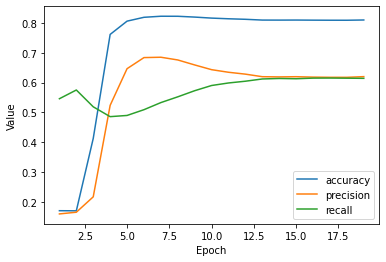

In [12]:
learning_rate = 0.001
epochs = 20
batch_size = 100
label_name = "median_house_value_is_high"
classification_threshold = 0.35

# metrics the model will measure
METRICS = [
           tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                           threshold=classification_threshold),
           tf.keras.metrics.Recall(name='recall', 
                                   thresholds=classification_threshold ),
           tf.keras.metrics.Precision(name='precision', 
                                      thresholds=classification_threshold),
          ]


my_model = create_model(learning_rate, feature_layer, METRICS)


epochs, hist = train_model(my_model, train_df_norm, epochs, 
                           label_name, batch_size)

# Plot a graph of the metrics vs epochs
list_of_metrics_to_plot = ['accuracy', 'precision', 'recall'] 

plot_curve(epochs, hist, list_of_metrics_to_plot)

## Evaluate the model against the test set

In [13]:
features = {name:np.array(value) for name, value in test_df_norm.items()}
label = np.array(features.pop(label_name))

my_model.evaluate(x = features, y = label, batch_size=batch_size)

30/30 [==============================] - 0s 1ms/step - loss: 0.4068 - accuracy: 0.8007 - recall: 0.5965 - precision: 0.5997


[0.40677037835121155,
 0.8006666898727417,
 0.5965147614479065,
 0.5997304320335388]

#### A model that always guesses median_house_value_is_high is False would be 75% accurate. Our model makes 80% accurate predictions, which is not that great.

## Adjusting the classification threshold 

Epoch 1/20
170/170 [==============================] - 0s 1ms/step - loss: 1.0544 - accuracy: 0.4231 - recall: 0.0951 - precision: 0.0634
Epoch 2/20
170/170 [==============================] - 0s 1ms/step - loss: 0.9243 - accuracy: 0.5364 - recall: 0.0450 - precision: 0.0475
Epoch 3/20
170/170 [==============================] - 0s 1ms/step - loss: 0.8112 - accuracy: 0.6903 - recall: 0.0111 - precision: 0.0423
Epoch 4/20
170/170 [==============================] - 0s 1ms/step - loss: 0.7154 - accuracy: 0.7496 - recall: 2.3546e-04 - precision: 0.0833
Epoch 5/20
170/170 [==============================] - 0s 1ms/step - loss: 0.6410 - accuracy: 0.7502 - recall: 0.0000e+00 - precision: 0.0000e+00
Epoch 6/20
170/170 [==============================] - 0s 1ms/step - loss: 0.5842 - accuracy: 0.7501 - recall: 4.7092e-04 - precision: 0.3333
Epoch 7/20
170/170 [==============================] - 0s 1ms/step - loss: 0.5408 - accuracy: 0.7501 - recall: 0.0026 - precision: 0.4583
Epoch 8/20
170/170 [=====

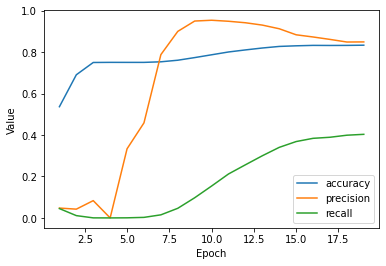

In [14]:
learning_rate = 0.001
epochs = 20
batch_size = 100
label_name = "median_house_value_is_high"
classification_threshold = 0.60

# metrics the model will measure
METRICS = [
           tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                           threshold=classification_threshold),
           tf.keras.metrics.Recall(name='recall', 
                                   thresholds=classification_threshold ),
           tf.keras.metrics.Precision(name='precision', 
                                      thresholds=classification_threshold),
          ]


my_model = create_model(learning_rate, feature_layer, METRICS)


epochs, hist = train_model(my_model, train_df_norm, epochs, 
                           label_name, batch_size)

# Plot a graph of the metrics vs epochs
list_of_metrics_to_plot = ['accuracy', 'precision', 'recall'] 

plot_curve(epochs, hist, list_of_metrics_to_plot)

#### Classification_threshold of 0.60 gives the highest accuracy (83.3%) and pecision (84.4%)

## Summarizing model performance with AUC

Epoch 1/20
170/170 [==============================] - 0s 1ms/step - loss: 0.6620 - auc: 0.6498
Epoch 2/20
170/170 [==============================] - 0s 1ms/step - loss: 0.5918 - auc: 0.8107
Epoch 3/20
170/170 [==============================] - 0s 1ms/step - loss: 0.5370 - auc: 0.8237
Epoch 4/20
170/170 [==============================] - 0s 1ms/step - loss: 0.4945 - auc: 0.8298
Epoch 5/20
170/170 [==============================] - 0s 1ms/step - loss: 0.4622 - auc: 0.8327
Epoch 6/20
170/170 [==============================] - 0s 1ms/step - loss: 0.4387 - auc: 0.8346
Epoch 7/20
170/170 [==============================] - 0s 1ms/step - loss: 0.4224 - auc: 0.8356
Epoch 8/20
170/170 [==============================] - 0s 1ms/step - loss: 0.4117 - auc: 0.8361
Epoch 9/20
170/170 [==============================] - 0s 1ms/step - loss: 0.4052 - auc: 0.8365
Epoch 10/20
170/170 [==============================] - 0s 1ms/step - loss: 0.4013 - auc: 0.8367
Epoch 11/20
170/170 [============================

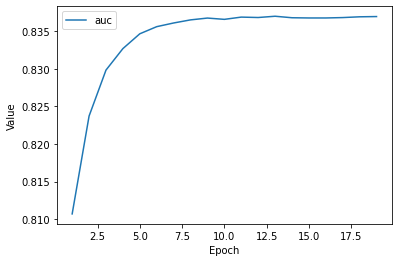

In [15]:
learning_rate = 0.001
epochs = 20
batch_size = 100
label_name = "median_house_value_is_high"

METRICS = [
      tf.keras.metrics.AUC(num_thresholds=100, name='auc'),
]


my_model = create_model(learning_rate, feature_layer, METRICS)


epochs, hist = train_model(my_model, train_df_norm, epochs, 
                           label_name, batch_size)

# Plot metrics vs epochs
list_of_metrics_to_plot = ['auc'] 
plot_curve(epochs, hist, list_of_metrics_to_plot)